# Project - Anomaly Detection

In [1]:
# imports
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import metrics
from random import randint
from matplotlib import style
import env
import warnings
warnings.filterwarnings("ignore")
import itertools

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler
# Pandas 
pd.set_option('display.max_row', None)

In [2]:
def check_columns(df, reports=False, graphs=False):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, the proportion of null values,
    the data type of the column, and the range of the column if it is float or int. The resulting dataframe is sorted by the
    'Number of Unique Values' column in ascending order.

    Args:
    - df: pandas dataframe

    Returns:
    - pandas dataframe
    """
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    if reports == True:
        describe = df.describe().round(2)
        pd.DataFrame(describe)
        print(describe)
    if graphs == True:
        df.hist(bins=20, figsize=(10, 10))
        plt.show()
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, proportion of null values, and data type to the data list
        if df[column].dtype in ["float64", "int64"]:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    df[column].describe()[["min", "max", "mean"]].values,
                ]
            )
        else:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    None,
                ]
            )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', 'Proportion of Null Values', 'dtype', and 'Range' (if column is float or int)
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "col_name",
            "dtype",
            "num_unique",
            "num_null",
            "pct_null",
            "unique_values",
            "range (min, max, mean)",
        ],
    )

## Acquire

In [3]:
colnames = ['date','time','path', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 1, 2, 3, 4, 5])
df.head()


,date,time,path,user_id,cohort_id,source_ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
#create SQL connection to logs
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
#SQL query
query = 'select * from cohorts'
df1 = pd.read_sql(query, url)

In [5]:
df1['name'].value_counts()

name
Arches                                    1
Staff                                     1
Ada                                       1
Andromeda                                 1
Betelgeuse                                1
Ceres                                     1
Bayes                                     1
Deimos                                    1
Europa                                    1
Fortuna                                   1
Curie                                     1
Apex                                      1
Ganymede                                  1
Hyperion                                  1
Darden                                    1
Io                                        1
Bash                                      1
Jupiter                                   1
Kalypso                                   1
Easley                                    1
Luna                                      1
Marco                                     1
Placeholder for students in

In [6]:
check_columns(df)

Total rows: 900223
Total columns: 6


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,date,object,1182,0,0.00000,"[2018-01-26, 2018-01-27, 2018-01-28, 2018-01-2...",None
1,time,object,73167,0,0.00000,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
2,path,object,2313,1,0.00000,"[/, java-ii, java-ii/object-oriented-programmi...",None
3,user_id,int64,981,0,0.00000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
4,cohort_id,float64,47,52893,0.05876,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, nan, ...","[1.0, 139.0, 48.501049178006205]"
5,source_ip,object,5531,0,0.00000,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None


In [7]:
# Set the index to datetime
# df.date = pd.to_datetime(df.date)
# df = df.set_index(df.date, drop=True)
# df = df.drop(columns='date')


In [8]:
# make another column for the endpoints
# df[['file_path', 'endpoints']] = 

df['endpoint'] = df['path'].str.split('/').str[-1]

In [9]:
df['startpoint'] = df['path'].str.split('/', n=1).str[0]

In [10]:
starter = df['startpoint'].unique().tolist()

In [11]:
starter

['',
 'java-ii',
 'slides',
 'javascript-i',
 'mkdocs',
 'git',
 'spring',
 'appendix',
 'index.html',
 'java-i',
 'html-css',
 'examples',
 'javascript',
 'mysql',
 'content',
 'jquery',
 'java',
 'javascript-ii',
 'teams',
 'java-iii',
 'prework',
 'asdf',
 'css',
 'single-page.html',
 'home',
 'assets',
 'forms',
 'css-i',
 'alumni-tech-survey-2018',
 'alumni-tech-survey-2018.html',
 'es6',
 'uploads',
 'introduction-to-java',
 'strings',
 'methods',
 'introduction',
 'elements',
 'file-io',
 'css-ii',
 'functions',
 'javascript-with-html',
 'conditionals',
 'bom-and-dom',
 'mvc',
 'students',
 'fundamentals',
 'setup',
 'group-by',
 'finish-the-adlister',
 'essential-methods',
 'ajax',
 'student',
 'hfdgafdja',
 'php',
 '.git',
 '.gitignore',
 'toc',
 'wp-admin',
 'wp-login',
 'registerUser',
 'search',
 'pre-work',
 'learn-to-code',
 'capstone-workbook',
 'jsp-and-jstl',
 'html',
 'handouts',
 'javascript-functions',
 'login',
 'quize',
 'cohorts',
 'PreWork',
 'app',
 'register.h

In [12]:
df.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,,
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,java-ii,java-ii
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,object-oriented-programming,java-ii
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,object_oriented_programming,slides
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,conditionals,javascript-i


In [13]:
df1.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1


In [14]:
df = df.fillna(value= -1)

In [15]:
check_columns(df)

Total rows: 900223
Total columns: 8


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,date,object,1182,0,0.0,"[2018-01-26, 2018-01-27, 2018-01-28, 2018-01-2...",None
1,time,object,73167,0,0.0,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
2,path,object,2314,0,0.0,"[/, java-ii, java-ii/object-oriented-programmi...",None
3,user_id,int64,981,0,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
4,cohort_id,float64,48,0,0.0,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, -1.0,...","[-1.0, 139.0, 45.592593168581566]"
5,source_ip,object,5531,0,0.0,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None
6,endpoint,object,1509,0,0.0,"[, java-ii, object-oriented-programming, objec...",None
7,startpoint,object,756,0,0.0,"[, java-ii, slides, javascript-i, mkdocs, git,...",None


In [16]:
df['cohort_id'] = df['cohort_id'].astype(int)

In [17]:
df0 = df.merge(df1, how='left', left_on= 'cohort_id', right_on='id')

In [18]:
df0.shape

(900223, 17)

In [19]:
df0.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [20]:
df0.date = pd.to_datetime(df0.date)
df0 = df0.set_index(df0.date, drop=True)
df0 = df0.drop(columns='date')

In [21]:
df0.head()

,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [22]:
check_columns(df0)

Total rows: 900223
Total columns: 16


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,time,object,73167,0,0.00000,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
1,path,object,2314,0,0.00000,"[/, java-ii, java-ii/object-oriented-programmi...",None
2,user_id,int64,981,0,0.00000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
3,cohort_id,int64,48,0,0.00000,"[8, 22, 21, 1, 16, 18, 19, -1, 13, 14, 15, 7, ...","[-1.0, 139.0, 45.592593168581566]"
4,source_ip,object,5531,0,0.00000,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None
5,endpoint,object,1509,0,0.00000,"[, java-ii, object-oriented-programming, objec...",None
6,startpoint,object,756,0,0.00000,"[, java-ii, slides, javascript-i, mkdocs, git,...",None
7,id,float64,47,52893,0.05876,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, nan, ...","[1.0, 139.0, 48.501049178006205]"
8,name,object,47,52893,0.05876,"[Hampton, Teddy, Sequoia, Arches, Niagara, Pin...",None
9,slack,object,46,52893,0.05876,"[#hampton, #teddy, #sequoia, #arches, #niagara...",None


## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?


Javascript i 

In [23]:
df0.program_id.value_counts()

program_id
2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: count, dtype: int64

In [24]:
# Program 1 dataframe
uno = df0[df0['program_id'] == 1]

<Axes: ylabel='path'>

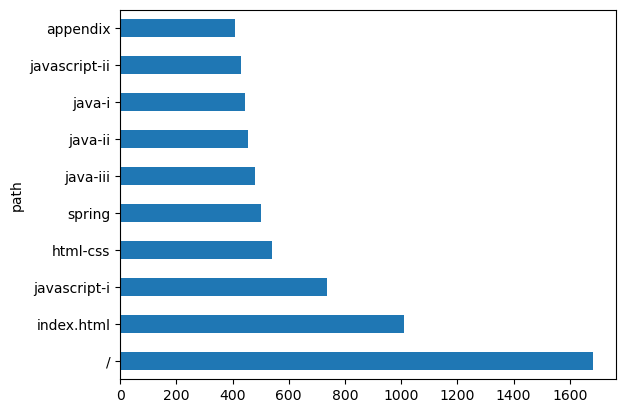

In [25]:
uno.path.value_counts().head(10).plot.barh()

javascript-i for cohorts with a program number of 1

In [26]:
# Program 2 dataframe
dos = df0[df0['program_id'] == 2]

<Axes: ylabel='path'>

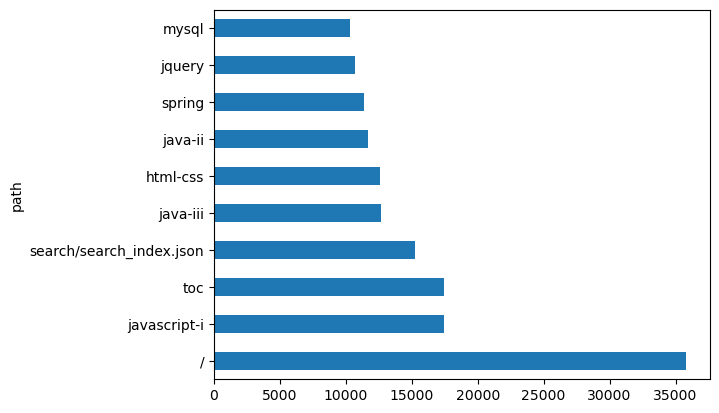

In [27]:
dos.path.value_counts().head(10).plot.barh()

spring for cohorts with a program number of 2

In [28]:
# Program 3 dataframe
tres = df0[df0['program_id'] == 3]

<Axes: ylabel='path'>

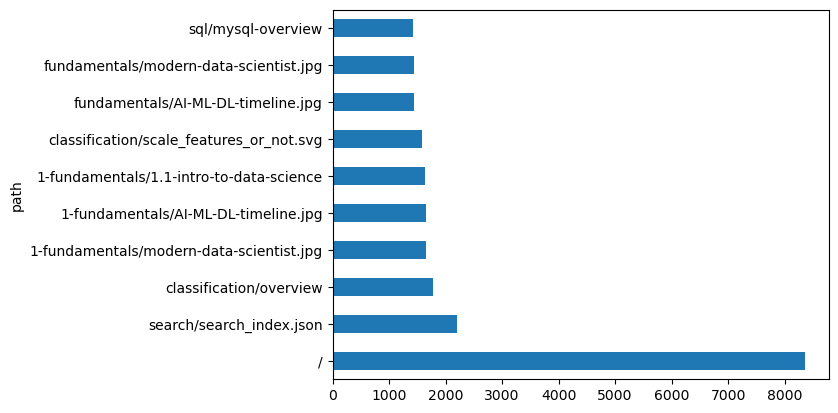

In [29]:
tres.path.value_counts().head(10).plot.barh()

appendix for cohorts with a program number 3

In [30]:
# Program 4 dataframe
quattro = df0[df0['program_id'] == 4]

<Axes: ylabel='path'>

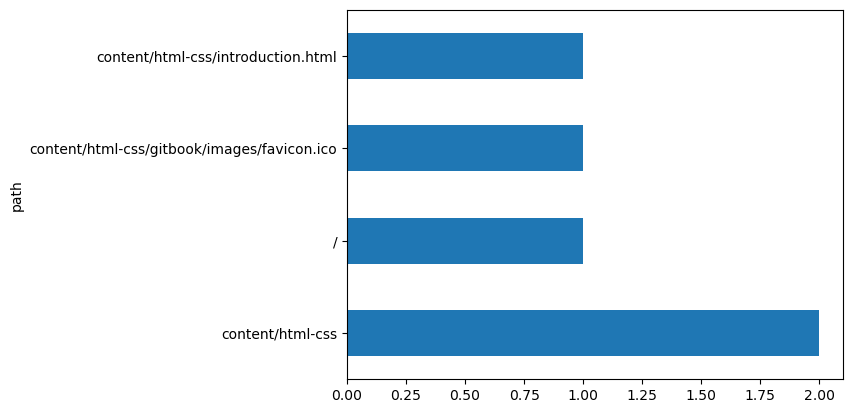

In [31]:
quattro.path.value_counts().head(10).plot.barh()

spring for cohorts with a program number of 4

## 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?


## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [32]:
# index between start_date and end_date for each user and do a count
df2 = df0.reset_index()

In [33]:
df2.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [34]:
# so by user_id, count amount of times they are hit on log, 
# and see if it is between start_date, and end_date
within_date = (df2['date'] >= df2['start_date']) & (df2['date'] <= df2['end_date'])
df[(df2['date'] >= df2['start_date']) & (df2['date'] <= df2['end_date'])].head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i
5,2018-01-26,09:56:41,javascript-i/loops,2,22,97.105.19.61,loops,javascript-i
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22,97.105.19.61,conditionals,javascript-i
7,2018-01-26,09:56:48,javascript-i/functions,3,22,97.105.19.61,functions,javascript-i
8,2018-01-26,09:56:59,javascript-i/loops,2,22,97.105.19.61,loops,javascript-i


## 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?


In [35]:
# create a function to prepare a df for analysis
# on the user by user basis:
def prep_user(df, user):
    '''
    will return a page count Series for a single user
    '''
    df_user = df[df.user_id == user]
    df_user.index = pd.to_datetime(df_user.index)
    return df_user['path'].resample('D').count()

In [36]:
prep_user(df, 1).head()

1970-01-01    7404
Freq: D, Name: path, dtype: int64

In [37]:
# lets build out the pieces to see percent b
# and return anomalies
def calculate_pb(user_series, span=30, k=3):
    midband = user_series.ewm(span=span).mean()
    upper_band = midband + (
        k * user_series.ewm(span=span).std())
    lower_band = midband - (
    k * user_series.ewm(span=span).std())
    bb_df_user = pd.DataFrame({
        'observed': user_series,
    'ub': upper_band,
    'lb': lower_band})
    bb_df_user['prcnt_b'] = (bb_df_user.observed - 
                             bb_df_user.lb) / (
    bb_df_user.ub - bb_df_user.lb)
    return bb_df_user

In [38]:
# steps so far:
user_series = prep_user(df, 1)
calculate_pb(user_series).head()

,observed,ub,lb,prcnt_b
1970-01-01,7404,NaN,NaN,NaN


In [39]:
def grab_anomalies(bb_df):
    return bb_df[bb_df['prcnt_b'] >= 1]

In [40]:
sus = pd.DataFrame()
for usr in df.user_id.unique():
    # resample page hits by the day for user:
    user_series = prep_user(df, usr)
    # get the bollanger band df for that user:
    bb_user = calculate_pb(user_series)
    # establish that we have the username associated with this
    # specific analysis:
    bb_user['user_id'] = usr
    # grab any rows where that user is breaching the bands
    anomalies = grab_anomalies(bb_user)
    sus = pd.concat([sus, anomalies], axis=0)

In [41]:
sus[['observed', 'prcnt_b', 'user_id']].head()

,observed,prcnt_b,user_id


## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?


## 7. Which lessons are least accessed?


In [42]:
# Need the endpoint count in ascending order
df['startpoint'].value_counts().sort_values(ascending=True).head(10)

startpoint
8_ts_split             1
modeling-lesson1       1
acquire-and-prep       1
javascri               1
10.00_Intro            1
6.03_Explore           1
mini_exercises         1
interview_questions    1
team                   1
viz.py                 1
Name: count, dtype: int64

8. Anything else I should be aware of?